In [ ]:
from google.colab import drive
import pandas as pd
from IPython.display import display
from google.colab import drive
from tqdm import tqdm

drive.mount('/content/drive')
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/data/processed/random_selected_articles_summaries_gpt_ner.csv'
df = pd.read_csv(csv_file_path)

Mounted at /content/drive


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the tokenizer and model
model_name = "JungleLee/bert-toxic-comment-classification"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
# Function to predict toxicity
def predict_toxicity(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

    # Make sure to use torch.no_grad() to prevent gradient calculation during inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the logits and apply softmax to get probabilities
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)

    # Get the predicted class (index of the highest probability)
    predicted_class = torch.argmax(probabilities, dim=-1).item()

    # Return the class and probabilities
    return predicted_class, probabilities.squeeze().numpy()

# Initialize a list to store results
results = []
toxicity_labels = ['Non-toxic', 'Toxic']
# Loop through articles and score them
for _, article in tqdm(df.iterrows()):
    # Score the cleaned article
    article_predicted_class, article_class_probabilities = predict_toxicity(article['cleaned_article'])

    # Score the summary
    summary_predicted_class, summary_class_probabilities = predict_toxicity(article['ner_summary'])

    # Append results to the list
    results.append({
        "Article Title": article['title'],  # Assuming you want to use the article's title
        "Article Predicted Class": toxicity_labels[article_predicted_class],
        "Article Class Probabilities": article_class_probabilities,
        "GPT Predicted Class": toxicity_labels[summary_predicted_class],
        "GPT Class Probabilities": summary_class_probabilities
    })


# Convert the results to a DataFrame
df = pd.DataFrame(results)

# Display the results in tabular format
display(df)

293it [03:56,  1.24it/s]


,Article Title,Article Predicted Class,Article Class Probabilities,GPT Predicted Class,GPT Class Probabilities
0,Poland abortion: Polish women look for help in...,Toxic,"[0.4129452, 0.5870547]",Non-toxic,"[0.99713266, 0.0028673043]"
1,Hong Kong Cardinal advocates for promoting a c...,Non-toxic,"[0.9947699, 0.0052301236]",Non-toxic,"[0.99810827, 0.0018916855]"
2,Sex Education in the Philippines - The Borgen ...,Non-toxic,"[0.99851114, 0.0014888949]",Non-toxic,"[0.9949092, 0.0050908094]"
3,"When a fetal scan showed problems, she fled Id...",Non-toxic,"[0.9523109, 0.047689006]",Non-toxic,"[0.9967769, 0.0032231708]"
4,Prioritizing the Neglected Areas of SRHR in Ca...,Non-toxic,"[0.9605853, 0.03941465]",Non-toxic,"[0.99751675, 0.0024832878]"
...,...,...,...,...,...
288,Pueblo Council decision on anti-abortion ordin...,Non-toxic,"[0.99731123, 0.0026888011]",Non-toxic,"[0.99778664, 0.0022132788]"
289,Louisiana House guts abortion bill that could ...,Non-toxic,"[0.9981511, 0.0018488077]",Non-toxic,"[0.99886876, 0.0011312255]"
290,Onslaught of new abortion restrictions looms i...,Non-toxic,"[0.8319686, 0.16803138]",Non-toxic,"[0.9981858, 0.0018141606]"
291,Indiana abortion clinics stop providing aborti...,Non-toxic,"[0.9900969, 0.009903074]",Non-toxic,"[0.9971328, 0.0028672102]"


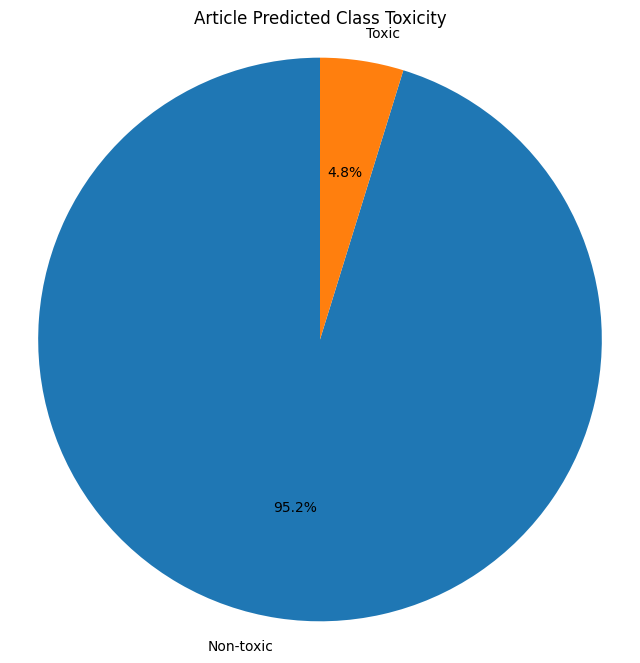

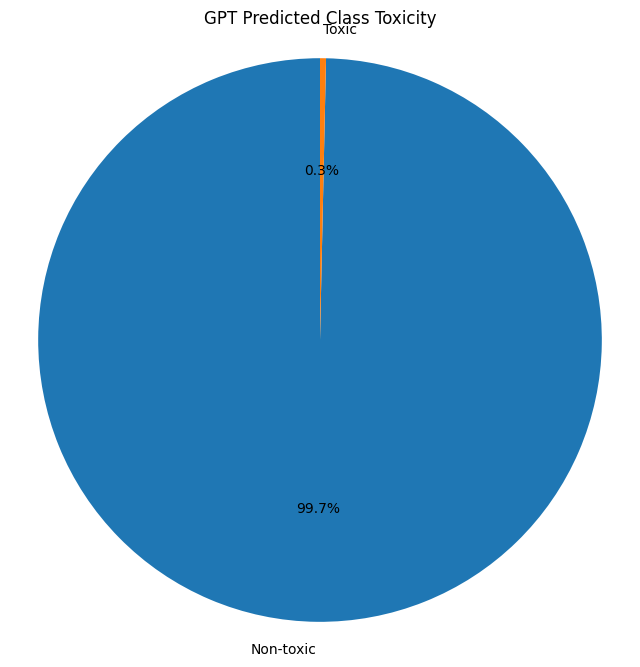

In [ ]:
# prompt: Using dataframe df: generate pie chart showing toxicity class for Article Predicted Class and GPT Predicted Class add percentage label using only matplotlib

import matplotlib.pyplot as plt

# Function to create pie chart with percentage labels
def create_pie_chart(data, title):
    # Count occurrences of each class
    class_counts = data.value_counts()

    # Create pie chart
    plt.figure(figsize=(8, 8))  # Adjust figure size as needed
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.show()

# Create pie chart for Article Predicted Class
create_pie_chart(df['Article Predicted Class'], 'Article Predicted Class Toxicity')

# Create pie chart for GPT Predicted Class
create_pie_chart(df['GPT Predicted Class'], 'GPT Predicted Class Toxicity')

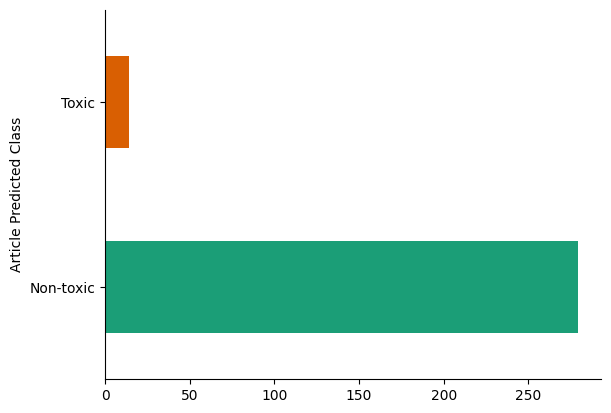

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Article Predicted Class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)